In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [4]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})
from matplotlib.ticker import PercentFormatter

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
tf.__version__

'2.2.0'

In [5]:
pickle_in = open("../data/oxygen.pickle", "rb")
oxygen = pickle.load(pickle_in)
oxygen.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
count,1.234100e+04,1.234100e+04,12341.000000,1.234100e+04,1.234100e+04,1.234100e+04,12341.000000
mean,1.274958e-14,-8.751519e-17,0.000000,8.060610e-17,-1.520001e-16,3.435202e-14,218.501794
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,23.150133
min,-2.035476e+00,-1.754102e+00,-0.036029,-1.421978e+00,-2.515894e+00,-3.751239e+00,109.900000
25%,-7.417802e-01,-8.565878e-01,-0.036029,-7.603727e-01,-7.337237e-01,-6.594490e-01,200.130000
50%,8.148080e-02,3.137826e-02,-0.036029,-9.876695e-02,-1.080223e-01,3.997917e-02,223.360000
75%,7.871331e-01,8.716042e-01,-0.036029,8.936417e-01,6.471345e-01,6.996671e-01,235.430000
max,1.728003e+00,1.721378e+00,27.753380,2.448415e+00,3.421796e+00,2.495926e+00,324.320000


In [6]:
## Train test split
train_dataset = oxygen.sample(frac=0.8, random_state=0)
test_dataset  = oxygen.drop(train_dataset.index)

In [7]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
7598,0.199090,1.014825,-0.036029,-1.421978,0.444321,0.206888,244.81
4261,-0.506563,-0.847040,-0.036029,-1.091176,1.514486,0.731459,225.60
13250,1.492785,-0.264610,-0.036029,-0.098767,-0.233163,0.802992,221.13
10166,0.787133,-0.789752,-0.036029,-1.421978,1.315988,0.024083,224.70
2950,-0.976998,1.396745,-0.036029,-1.091176,0.772275,0.310213,247.49


In [8]:
train_labels = train_dataset.pop('OXYGEN_VALUE')
test_labels = test_dataset.pop('OXYGEN_VALUE')

### The Model

In [9]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = keras.optimizers.Adam(lr=0.001)
    
    model.compile(loss=tf.keras.losses.mean_absolute_percentage_error,
                 optimizer=optimizer,
                 metrics=['mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [43]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#       layers.Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(1)
    ])
    
    optimizer = 'adam' #tf.keras.optimizers.RMSprop()
    
    model.compile(loss=tf.keras.losses.mean_absolute_percentage_error,
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [10]:
model = build_model()
minx = model.evaluate(train_dataset, train_labels)[0]
numtries = 0
while (numtries < 25):
    tmpmodel = build_model()
    x = tmpmodel.evaluate(train_dataset, train_labels)[0]
    if x < minx:
        model = tmpmodel
        minx = x
    numtries += 1
minx        

309/309 [==============================] - 0s 804us/step - loss: 100.0495 - mae: 218.4810 - mse: 48272.8867 - mean_absolute_percentage_error: 100.0495


99.8291015625

In [11]:
savedmodel = model

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [20]:
model = savedmodel

In [11]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')
# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=70)

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), es_callback])

loss: 52.3039, val_loss: 14.3045
..........loss:  4.3519, val_loss:  4.5948
..........loss:  4.1474, val_loss:  4.6522
..........loss:  4.0572, val_loss:  4.4499
..........loss:  3.9985, val_loss:  4.2804
..........loss:  3.9648, val_loss:  4.4168
..........loss:  3.9699, val_loss:  4.2174
..........loss:  3.9215, val_loss:  4.2616
..........loss:  3.9223, val_loss:  4.2737
..........loss:  3.9123, val_loss:  4.2401
..........loss:  3.8935, val_loss:  4.3484
..........loss:  3.9023, val_loss:  4.2853
..........loss:  3.8986, val_loss:  4.2288
..........loss:  3.8567, val_loss:  4.3257
..........loss:  3.8321, val_loss:  4.2336
..........loss:  3.8308, val_loss:  4.1897
..........loss:  3.8106, val_loss:  4.1922
..........loss:  3.7964, val_loss:  4.2380
..........loss:  3.8067, val_loss:  4.3601
..........loss:  3.8238, val_loss:  4.3174
..........loss:  3.8014, val_loss:  4.2076
..........loss:  3.7815, val_loss:  4.3328
..........loss:  3.8072, val_loss:  4.1396
..........loss:  3.76

KeyboardInterrupt: 

In [55]:
train_dataset.keys()

Index(['Year', 'Yday', 'Hour', 'PRESSURE', 'TEMPERATURE_VALUE',
       'SALINITY_VALUE', 'OXYGEN_VALUE'],
      dtype='object')

In [13]:
pd.DataFrame(history.history)

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
0,48.032555,105.198868,18034.947266,48.032555,13.414144,29.490795,1744.206177,13.414144
1,10.411343,22.701576,923.995300,10.411343,8.362842,18.338181,569.940613,8.362842
2,7.101637,15.365493,387.664490,7.101637,6.406868,13.783736,321.835114,6.406868
3,5.860503,12.554564,268.858826,5.860503,5.682076,12.121263,261.055756,5.682076
4,5.351395,11.414758,233.847107,5.351395,5.333548,11.421774,240.486038,5.333548
...,...,...,...,...,...,...,...,...
297,3.725269,7.962499,128.659134,3.725269,4.158061,8.943515,163.638199,4.158061
298,3.769320,8.059966,130.360626,3.769320,4.154161,8.858701,161.477692,4.154161
299,3.767779,8.058097,130.062988,3.767779,4.324790,9.366349,174.240280,4.324790
300,3.769547,8.060347,130.029648,3.769547,4.191219,8.952865,164.454346,4.191219


In [12]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([100,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  plt.show()


plot_history(history)

NameError: name 'history' is not defined

In [26]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,124.105141,8.044875,124.105143,3.772340,133.628096,8.503744,133.628095,3.946359
std,5.019757,0.177361,5.019758,0.083227,4.749098,0.212164,4.749098,0.099593
min,115.998774,7.751125,115.998795,3.634219,125.249854,8.130034,125.249855,3.764160
25%,120.222926,7.905116,120.222910,3.706797,130.151139,8.348971,130.151138,3.875533
50%,122.832589,7.999689,122.832600,3.750814,133.008074,8.473672,133.008087,3.930791
75%,127.342597,8.157766,127.342588,3.824708,136.167953,8.608869,136.167953,4.002208
max,138.215576,8.559223,138.215591,4.012484,165.588207,9.861861,165.588226,4.612249


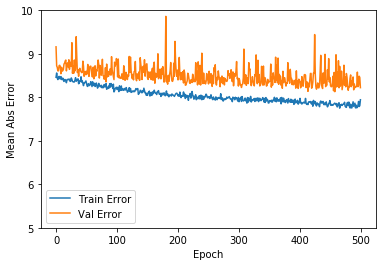

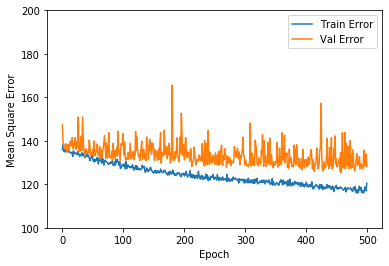

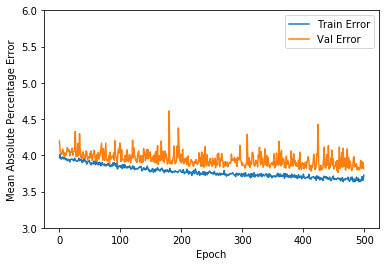

In [39]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([100,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  plt.ylim([3,6])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute\n Percentage Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
         label='Train loss')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
         label = 'Val loss')
plt.ylim([3,10])
plt.legend()
plt.show()

In [5]:
with open("../data/oxygen_model_history.pickle", "rb") as pickle_in:
    hist = pickle.load(pickle_in)

In [7]:
with open("../data/nitrate_model_mseloss_l2regularization_history.pickle", "rb") as pickle_in:
    hist1 = pickle.load(pickle_in)
with open("../data/nitrate_model_mseloss_l2regularization_O2_history.pickle", "rb") as pickle_in:
    hist2 = pickle.load(pickle_in)

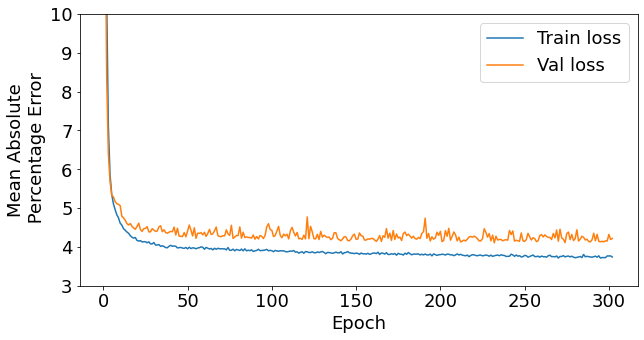

In [6]:
# hist = pd.DataFrame(history.history)
hist['epoch'] = np.arange(1, len(hist)+1, 1)
plt.figure(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute\n Percentage Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
         label='Train loss')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
         label = 'Val loss')
plt.ylim([3,10])
plt.legend()
plt.show()

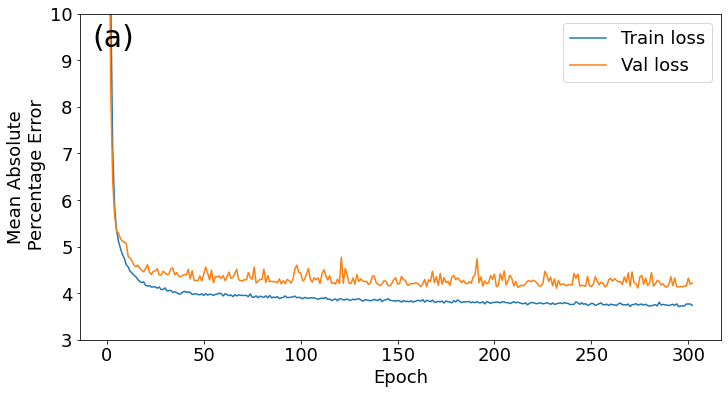

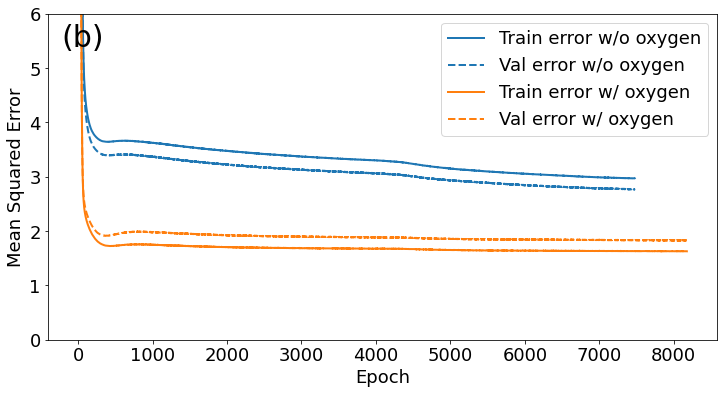

In [12]:
# hist = pd.DataFrame(history.history)
hist['epoch'] = np.arange(1, len(hist)+1, 1)
fig, ax = plt.subplots(figsize=(11.5,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute\n Percentage Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
         label='Train loss')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
         label = 'Val loss')
plt.ylim([3,10])
plt.text(0.02, 0.9, "(a)", transform=ax.transAxes, fontsize=30)
plt.legend()

# hist = pd.DataFrame(history.history)
hist1['epoch'] = np.arange(1, len(hist1)+1, 1) #history.epoch
hist2['epoch'] = np.arange(1, len(hist2)+1, 1)
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
line, = ax.plot(hist1['epoch'], hist1['mse'], linewidth=2,
         label='Train error w/o oxygen')
plt.plot(hist1['epoch'], hist1['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/o oxygen')
line, = ax.plot(hist2['epoch'], hist2['mse'], linewidth=2,
         label='Train error w/ oxygen')
plt.plot(hist2['epoch'], hist2['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/ oxygen')
# plt.title('Nitrate model without oxygen as a feature')
plt.text(0.02, 0.9, "(b)", transform=ax.transAxes, fontsize=30)
plt.ylim([0,6])
plt.legend()

plt.show()

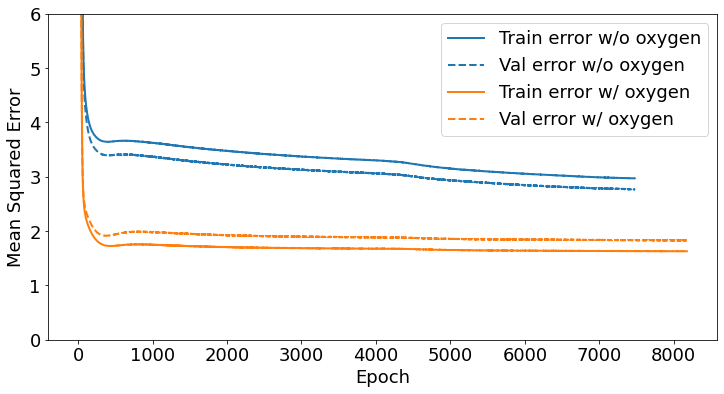

In [6]:
# hist = pd.DataFrame(history.history)
hist1['epoch'] = np.arange(1, len(hist1)+1, 1) #history.epoch
hist2['epoch'] = np.arange(1, len(hist2)+1, 1)
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
line, = ax.plot(hist1['epoch'], hist1['mse'], linewidth=2,
         label='Train error w/o oxygen')
plt.plot(hist1['epoch'], hist1['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/o oxygen')
line, = ax.plot(hist2['epoch'], hist2['mse'], linewidth=2,
         label='Train error w/ oxygen')
plt.plot(hist2['epoch'], hist2['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/ oxygen')
# plt.title('Nitrate model without oxygen as a feature')
# plt.text(0.02, 0.9, "(a)", transform=ax.transAxes, fontsize=30)
plt.ylim([0,6])
plt.legend()

# hist = history2
# hist2['epoch'] = np.arange(1, len(hist2)+1, 1)
# fig, ax = plt.subplots(figsize=(10,5))
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.plot(hist2['epoch'], hist2['mse'],
#          label='Train Error')
# plt.plot(hist2['epoch'], hist2['val_mse'],
#          label = 'Val Error')
# plt.title('Nitrate model with oxygen as a feature')
# plt.text(0.02, 0.9, "(b)", transform=ax.transAxes, fontsize=30)
# plt.ylim([0,6])
# plt.legend()

# plt.show()

In [15]:
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

78/78 - 0s - loss: 3.9673 - mae: 8.5236 - mse: 146.7454 - mean_absolute_percentage_error: 3.9673
Testing set Mean Abs Percentage Error:  3.97


In [ ]:
## Make predictions
test_predictions = model.predict(test_dataset).flatten()

In [17]:
min(test_predictions), max(test_predictions)

(167.20279, 260.35123)

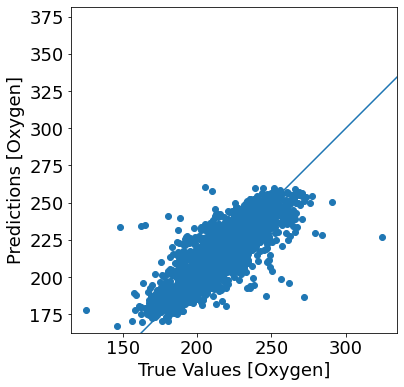

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(test_labels, test_predictions)
# plt.ylim([160,270])
plt.xlabel('True Values [Oxygen]')
plt.ylabel('Predictions [Oxygen]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

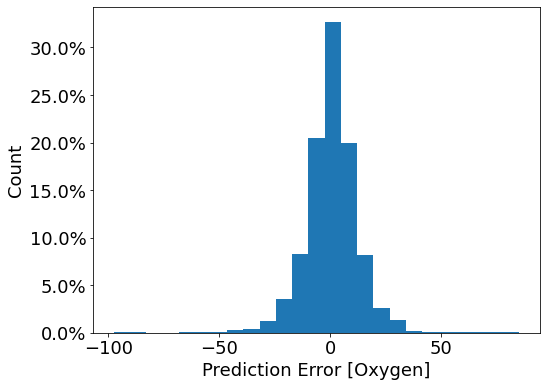

In [19]:
from matplotlib.ticker import PercentFormatter
error = test_predictions - test_labels
plt.figure(figsize=(8,6))
plt.hist(error, bins = 25, weights=np.ones(len(error)) / len(error))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Prediction Error [Oxygen]")
_ = plt.ylabel("Count")

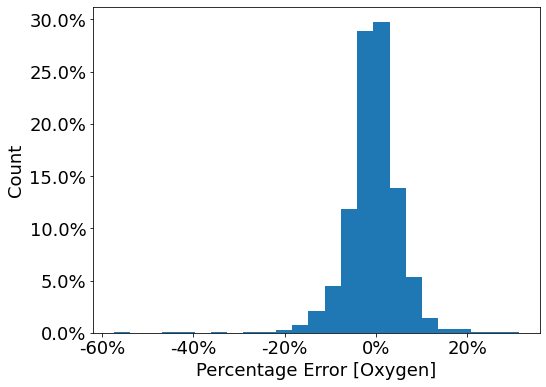

In [20]:
error = (test_labels - test_predictions)/test_labels
plt.figure(figsize=(8,6))
plt.hist(error, bins = 25, weights=np.ones(len(error)) / len(error))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Percentage Error [Oxygen]")
_ = plt.ylabel("Count")

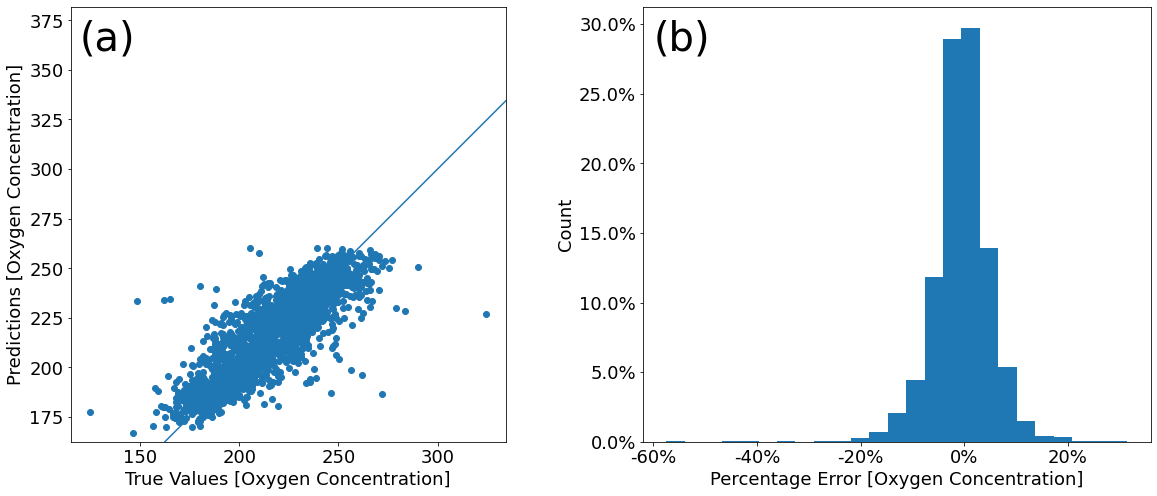

In [31]:
# plt.figure(figsize=(6,6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].scatter(test_labels, test_predictions)
axes[0].set_xlabel('True Values [Oxygen Concentration]')
axes[0].set_ylabel('Predictions [Oxygen Concentration]')
axes[0].axis('equal')
axes[0].axis('square')
axes[0].text(0.02,0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
_ = axes[0].plot([-300, 500], [-300, 500])


# plt.figure(figsize=(8,6))
error = (test_labels - test_predictions)/test_labels
axes[1].hist(error, bins = 25,  weights=np.ones(len(error)) / len(error))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_xlabel("Percentage Error [Oxygen Concentration]")
axes[1].text(0.02,0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
_ = axes[1].set_ylabel("Count")

In [28]:
## Save model
model.save('../data/saved_models/oxygen_model.h5')

In [29]:
# save history
pickle_out = open("../data/oxygen_model_history.pickle", "wb")
pickle.dump(pd.DataFrame(history.history), pickle_out)
pickle_out.close()

## Load Model

In [12]:
model = keras.models.load_model('../data/saved_models/oxygen_model.h5')

In [13]:
pickle_in = open("../data/oxygen_model_history.pickle", "rb")
hist = pickle.load(pickle_in)
pickle_in.close()

In [14]:
hist

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
0,48.032555,105.198868,18034.947266,48.032555,13.414144,29.490795,1744.206177,13.414144
1,10.411343,22.701576,923.995300,10.411343,8.362842,18.338181,569.940613,8.362842
2,7.101637,15.365493,387.664490,7.101637,6.406868,13.783736,321.835114,6.406868
3,5.860503,12.554564,268.858826,5.860503,5.682076,12.121263,261.055756,5.682076
4,5.351395,11.414758,233.847107,5.351395,5.333548,11.421774,240.486038,5.333548
...,...,...,...,...,...,...,...,...
297,3.725269,7.962499,128.659134,3.725269,4.158061,8.943515,163.638199,4.158061
298,3.769320,8.059966,130.360626,3.769320,4.154161,8.858701,161.477692,4.154161
299,3.767779,8.058097,130.062988,3.767779,4.324790,9.366349,174.240280,4.324790
300,3.769547,8.060347,130.029648,3.769547,4.191219,8.952865,164.454346,4.191219


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [15]:
test_predictions = model.predict(test_dataset).flatten()
error = test_predictions - test_labels

In [14]:
np.percentile(error, [2.5, 5, 95, 97.5])

array([-22.19529938, -16.60290347,  18.65565204,  23.59064091])

In [15]:
test_dataset

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
0,-2.068154,-0.312288,-0.035143,-1.160867,0.456576,-0.107644
13,-2.068154,-0.226590,-0.035143,0.057929,0.124859,-0.107644
29,-2.068154,-0.036150,-0.035143,0.057929,0.041930,0.111396
33,-2.068154,0.020981,-0.035143,-0.917108,-0.123928,0.001876
34,-2.068154,0.020981,-0.035143,-0.673349,-0.123928,-0.332768
...,...,...,...,...,...,...
13830,1.613731,1.468321,-0.035143,1.288913,-1.072222,-0.710003
13831,1.613731,1.525453,-0.035143,-1.160867,1.210401,0.628573
13842,1.613731,1.592107,-0.035143,-0.429590,0.516699,1.164003
13845,1.613731,1.592107,-0.035143,0.667327,-0.449010,0.014045


In [16]:
# test dataset rescaled
pickle_in = open("../data/standardisation_oxygen.pickle", "rb")
oxygen_stats = pickle.load(pickle_in)
pickle_in.close()

In [17]:
rescaled_test_dataset = test_dataset * oxygen_stats['std'] + oxygen_stats['mean']

In [18]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})

Text(0, 0.5, 'Salinity (g/m^3)')

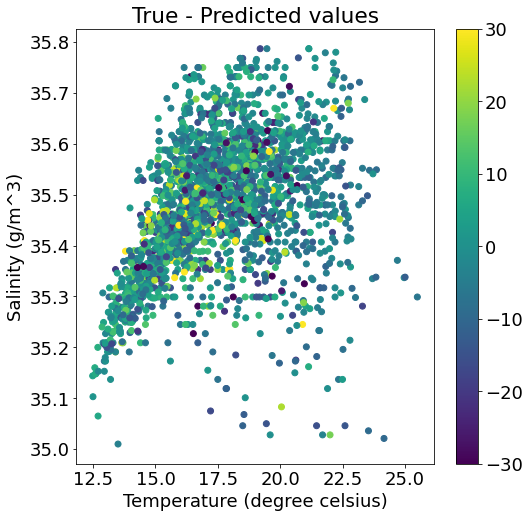

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_labels-test_predictions, vmin=-30, vmax=30)
plt.colorbar()
plt.title("True - Predicted values")
plt.xlabel("Temperature (degree celsius)")
plt.ylabel("Salinity (g/m^3)")

In [19]:
#load nitrate data and model
# test_dataset and test_labels
pickle_in = open("../data/nitrate_train-test_data-labels.pickle", "rb")
data = pickle.load(pickle_in)
nitrate_test_dataset = data[1]
nitrate_test_labels = data[3]
pickle_in.close()
# Now load the model
nitrate_model = keras.models.load_model('../data/saved_models/nitrate_model_mseloss_l2regularization.h5')
# calc test_predictions
nitrate_test_predictions = nitrate_model.predict(nitrate_test_dataset).flatten()
# Now standardization data
pickle_in = open("../data/standardisation_nitrate.pickle", "rb")
nitrate_stats = pickle.load(pickle_in)
pickle_in.close()
# Now rescale test_dataset
rescaled_nitrate_test_dataset = nitrate_test_dataset * nitrate_stats['std'] + nitrate_stats['mean']

Text(0, 0.5, 'Salinity (g/m^3)')

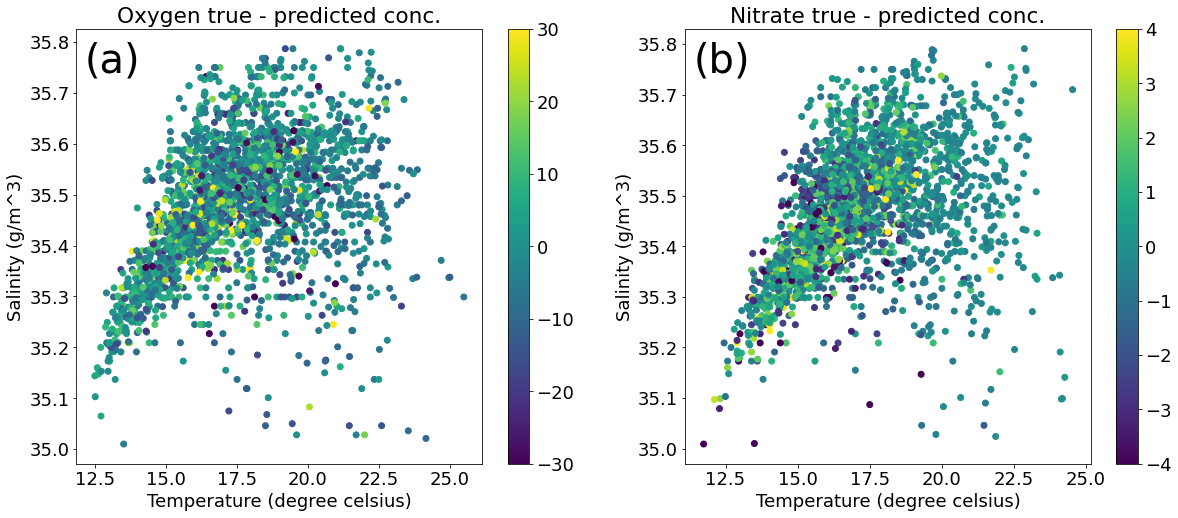

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

im = axes[0].scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_labels-test_predictions, vmin=-30, vmax=30)
fig.colorbar(im, ax=axes[0])
axes[0].text(0.02, 0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
axes[0].set_title("Oxygen true - predicted conc.")
axes[0].set_xlabel("Temperature (degree celsius)")
axes[0].set_ylabel("Salinity (g/m^3)")

im = axes[1].scatter(rescaled_nitrate_test_dataset.TEMPERATURE_VALUE, rescaled_nitrate_test_dataset.SALINITY_VALUE, c=nitrate_test_labels-nitrate_test_predictions, vmin=-4, vmax=4)
fig.colorbar(im, ax=axes[1])
axes[1].text(0.02, 0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
axes[1].set_title("Nitrate true - predicted conc.")
axes[1].set_xlabel("Temperature (degree celsius)")
axes[1].set_ylabel("Salinity (g/m^3)")

Text(0, 0.5, 'Salinity (g/m^3)')

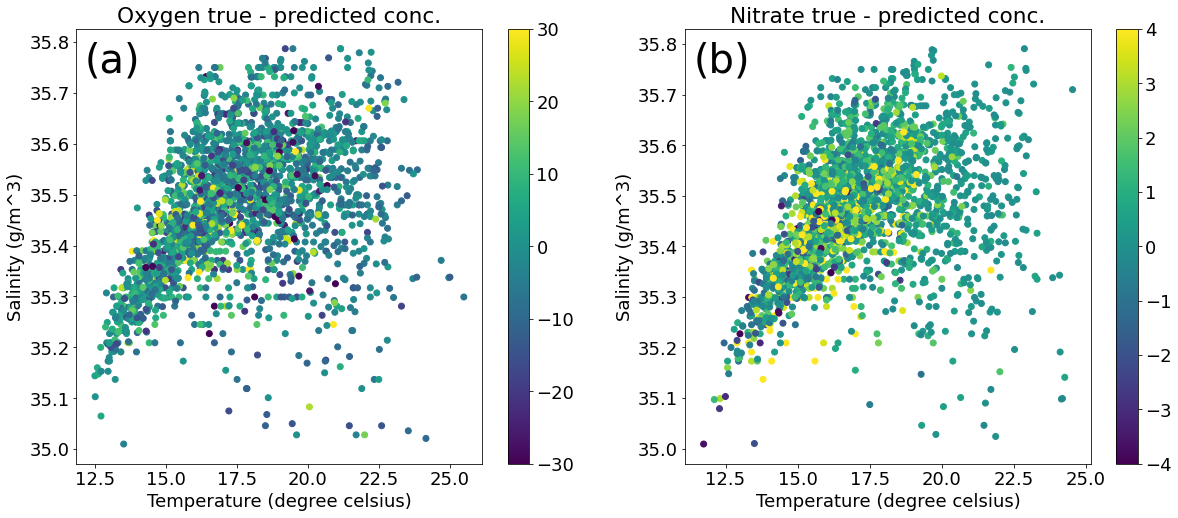

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

im = axes[0].scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_labels-test_predictions, vmin=-30, vmax=30)
fig.colorbar(im, ax=axes[0])
axes[0].text(0.02, 0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
axes[0].set_title("Oxygen true - predicted conc.")
axes[0].set_xlabel("Temperature (degree celsius)")
axes[0].set_ylabel("Salinity (g/m^3)")

im = axes[1].scatter(rescaled_nitrate_test_dataset.TEMPERATURE_VALUE, rescaled_nitrate_test_dataset.SALINITY_VALUE, c=nitrate_test_labels-nitrate_test_predictions, vmin=-4, vmax=4)
fig.colorbar(im, ax=axes[1])
axes[1].text(0.02, 0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
axes[1].set_title("Nitrate true - predicted conc.")
axes[1].set_xlabel("Temperature (degree celsius)")
axes[1].set_ylabel("Salinity (g/m^3)")

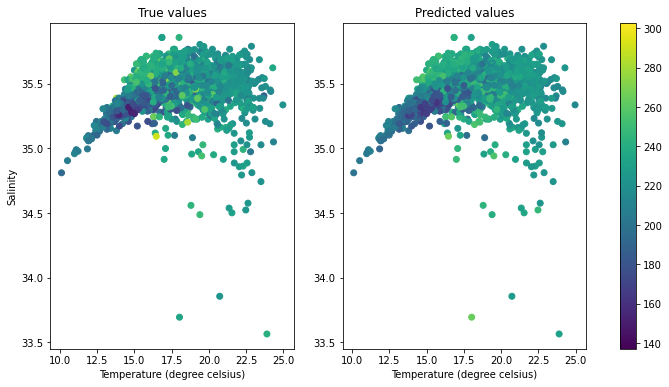

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

sctr = axes[0].scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_labels, vmin=test_labels.min(), vmax=test_labels.max())
axes[0].set_title("True values")
axes[0].set_xlabel("Temperature (degree celsius)")
axes[0].set_ylabel("Salinity")
axes[1].scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_predictions, vmin=test_labels.min(), vmax=test_labels.max())
axes[1].set_title("Predicted values")
axes[1].set_xlabel("Temperature (degree celsius)")
fig.colorbar(sctr, ax=axes.ravel().tolist())


In [61]:
import datetime

In [62]:
yd = [datetime.timedelta(yd - 1) for yd in rescaled_test_dataset.Yday.astype(int)]
y = [datetime.datetime(y, 1, 1) for y in rescaled_test_dataset.Year.astype(int)] 

In [63]:
time = [a + b for a,b in zip(y, yd)] 

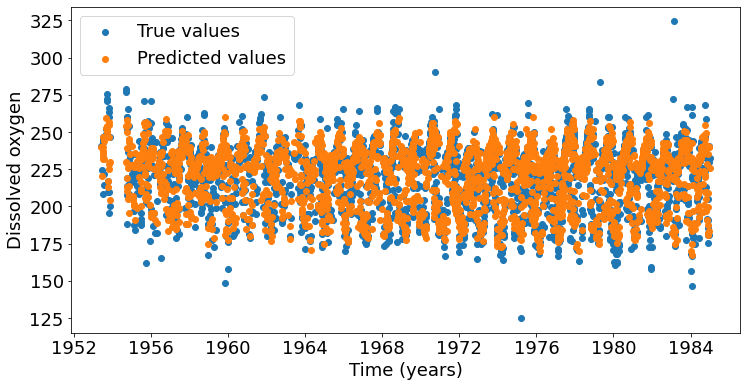

In [64]:
plt.figure(figsize=(12,6))
plt.scatter(time, test_labels, label="True values")
plt.scatter(time, test_predictions, label="Predicted values")
plt.xlabel("Time (years)")
plt.ylabel("Dissolved oxygen")
plt.legend()

## Application: Predict based on Moorning data

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [29]:
# Load PH100 Mooring data
wqm_ds = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_OZ_20100504_PH100_FV01_DOX2-aggregated-timeseries_END-20170828_C-20190819.nc') 

In [30]:
wqm_ds

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 33, OBSERVATION: 12073463)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    DOX2                      (OBSERVATION) float32 ...
    DOX2_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [31]:
# Nominal depth location of WQM sensors
np.unique(wqm_ds.NOMINAL_DEPTH.values)

array([15. , 15.5, 24. ], dtype=float32)

In [32]:
# Drop unecessary variables and export to dataframe
wqm_ds = wqm_ds.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [33]:
# filter out bad quality data 
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.DOX2_quality_control > 0, wqm_ds.DOX2_quality_control < 3), drop = True)

In [34]:
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.PRES_REL_quality_control > 0, wqm_ds.PRES_REL_quality_control < 3), drop = True)

In [35]:
# create pd dataframe from scratch
data  = {'TIME': wqm_ds.TIME.values,
         'DOX2': wqm_ds.DOX2.values,
         'PRES': wqm_ds.PRES_REL.values}

wqm_df = pd.DataFrame(data, columns = ['TIME','DOX2','PRES'])
# set TIME as the indexing variable
wqm_df = wqm_df.set_index('TIME')

In [36]:
wqm_df

,DOX2,PRES
TIME,,
2010-05-04 02:00:00.000003328,191.253952,28.760000
2010-05-04 02:00:01.000007936,191.167465,28.799999
2010-05-04 02:00:02.000002560,191.140900,28.840000
2010-05-04 02:00:03.000007168,191.029449,28.870001
2010-05-04 02:00:04.000001792,191.110626,28.870001
...,...,...
2017-08-27 18:30:19.000000768,212.614594,17.709999
2017-08-27 18:30:20.000005632,212.614273,17.830000
2017-08-27 18:30:21.000000000,212.701523,17.910000


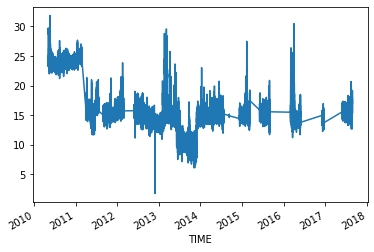

In [37]:
# Plot PRES over TIME
wqm_df.PRES.plot()

In [38]:
# save maximum pressure value for subsetting temperature later
max_pres = wqm_df.PRES.max()

In [39]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [40]:
# create a column with pressure bin labels
wqm_df['PRES_BIN'] = pd.cut(wqm_df.PRES, bins = bins, labels = labs)

In [41]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
wqm_df = wqm_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [42]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

Text(0.5, 1.0, 'DOX2 concentration as 15dbar depth')

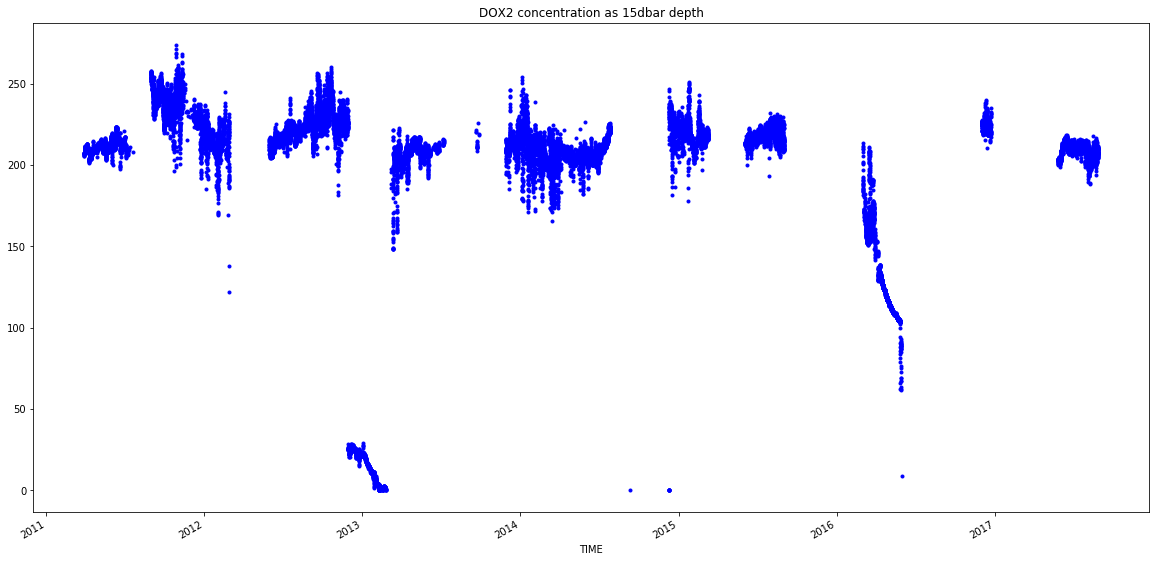

In [43]:
wqm_df.xs(15).DOX2.plot(style=['.b'],figsize=(20,10))
plt.title('DOX2 concentration as 15dbar depth')

### Temperature data 

In [44]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [45]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [46]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  16. ,  24. ,  32. ,  40. ,  48. ,  56. ,  64. ,
        72. ,  80. ,  88. ,  96. , 104. , 109.5, 110. ], dtype=float32)

In [47]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [48]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [49]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [50]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [51]:
# subset to the same dates water quality measurements
temp_df = temp_df.loc['2010-05-04 02':'2017-8-27 18']

In [52]:
# subset to same pressure range as WQM
temp_df = temp_df.where(temp_df.PRES <= max_pres).dropna()

In [53]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

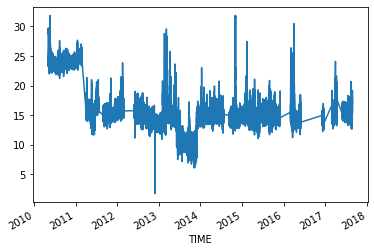

In [54]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [55]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [56]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [57]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [58]:
temp_df

TEMP
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  20.759911
3.0      2012-11-28 22:00:00  20.770100
7.0      2013-06-15 07:00:00  19.003767
         2013-06-15 08:00:00  18.982601
         2013-06-15 21:00:00  18.965900
...                                 ...
31.0     2014-11-04 08:00:00  19.540016
         2014-11-04 09:00:00  19.641979
         2014-11-04 10:00:00  19.633989
         2016-04-01 05:00:00  24.785011
         2016-04-01 06:00:00  24.770300

[75665 rows x 1 columns]

In [59]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

In [60]:
# Join wqm_df and temp_df
mooring_df = wqm_df.join(temp_df, how='inner')

In [61]:
mooring_df

DOX2       TEMP
PRES_BIN TIME                                      
1.0      2012-11-28 22:00:00  219.715591  20.759911
3.0      2012-11-28 22:00:00  219.631363  20.770100
7.0      2013-06-15 07:00:00  205.350891  19.003767
         2013-06-15 08:00:00  205.339203  18.982601
         2013-06-15 21:00:00  208.561523  18.965900
...                                  ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212
         2010-05-21 11:00:00  210.027222  22.679289
         2010-05-21 12:00:00  209.906219  22.679312
         2016-04-01 05:00:00  161.294037  24.785011
         2016-04-01 06:00:00  162.787338  24.770300

[62732 rows x 2 columns]

### Salinity data

In [62]:
psal = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_SZ_20100504_PH100_FV01_PSAL-aggregated-timeseries_END-20190612_C-20190822.nc')

In [63]:
psal

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 50, OBSERVATION: 12502147)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    PSAL                      (OBSERVATION) float32 ...
    PSAL_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [64]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(psal.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  24. , 104. ], dtype=float32)

In [65]:
psal = psal.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [66]:
psal = psal.where(np.logical_and(psal.PSAL_quality_control > 0, psal.PSAL_quality_control < 3), drop = True)

In [67]:
psal = psal.where(np.logical_and(psal.PRES_REL_quality_control > 0, psal.PRES_REL_quality_control < 3), drop = True) 

In [68]:
# create pd dataframe from scratch
data  = {'TIME': psal.TIME.values,
         'PSAL': psal.PSAL.values,
         'PRES': psal.PRES_REL.values}

psal_df= pd.DataFrame(data, columns = ['TIME','PSAL','PRES'])
# set TIME as the indexing variable
psal_df = psal_df.set_index('TIME')

In [69]:
# subset to the same dates water quality measurements
psal_df = psal_df.loc['2010-05-04 02':'2017-8-27 18']

In [70]:
# subset to same pressure range as WQM
psal_df = psal_df.where(psal_df.PRES <= max_pres).dropna()

In [71]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

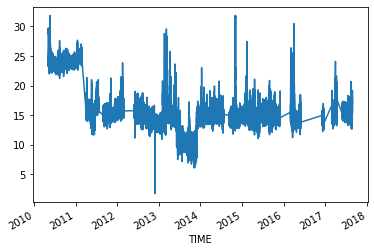

In [72]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
psal_df.PRES.plot()

In [73]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [74]:
# create a column with pressure bin labels
psal_df['PRES_BIN'] = pd.cut(psal_df.PRES, bins = bins, labels = labs)

In [75]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
psal_df = psal_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [76]:
psal_df

PSAL
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  35.461388
3.0      2012-11-28 22:00:00  35.460751
7.0      2013-06-15 07:00:00  35.462334
         2013-06-15 08:00:00  35.463001
         2013-06-15 21:00:00  35.501999
...                                 ...
31.0     2014-11-04 08:00:00  35.632832
         2014-11-04 09:00:00  35.634396
         2014-11-04 10:00:00  35.633755
         2016-04-01 05:00:00  35.544964
         2016-04-01 06:00:00  35.544453

[75665 rows x 1 columns]

In [77]:
# Join with mooring_df
mooring_df = mooring_df.join(psal_df, how="inner")

In [78]:
mooring_df

DOX2       TEMP       PSAL
PRES_BIN TIME                                                 
1.0      2012-11-28 22:00:00  219.715591  20.759911  35.461388
3.0      2012-11-28 22:00:00  219.631363  20.770100  35.460751
7.0      2013-06-15 07:00:00  205.350891  19.003767  35.462334
         2013-06-15 08:00:00  205.339203  18.982601  35.463001
         2013-06-15 21:00:00  208.561523  18.965900  35.501999
...                                  ...        ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212  35.327530
         2010-05-21 11:00:00  210.027222  22.679289  35.324860
         2010-05-21 12:00:00  209.906219  22.679312  35.319817
         2016-04-01 05:00:00  161.294037  24.785011  35.544964
         2016-04-01 06:00:00  162.787338  24.770300  35.544453

[62732 rows x 3 columns]

In [79]:
# reset indices and split TIME into YEAR YDAY and HOUR
mooring_df = mooring_df.reset_index()

In [80]:
import datetime

In [81]:
mooring_df['Year'] = mooring_df.TIME.dt.year
mooring_df['Yday'] = mooring_df.TIME.dt.dayofyear#pd.to_numeric(mooring_df.TIME.dt.strftime('%j'))
mooring_df['Hour'] = mooring_df.TIME.dt.hour

In [82]:
mooring_df.rename(columns={'PRES_BIN': 'PRESSURE', 'DOX2': 'OXYGEN_VALUE', 'TEMP': 'TEMPERATURE_VALUE', 'PSAL': 'SALINITY_VALUE'}, inplace=True)

In [83]:
# Normalise columns for prediction, similar to training data

In [84]:
import pickle

In [85]:
pickle_in = open("../data/standardisation_oxygen.pickle", "rb")
oxygen_stats = pickle.load(pickle_in)
oxygen_stats

,count,mean,std,min,25%,50%,75%,max
Year,12970.0,1970.413030,8.419602,1953.000,1964.00000,1971.00,1977.00,1985.000
Yday,12970.0,183.796530,105.020247,1.000,92.00000,187.00,275.00,365.000
Hour,12970.0,0.028373,0.807359,0.000,0.00000,0.00,0.00,23.000
PRESSURE,12970.0,47.623531,41.024090,0.000,20.00000,40.00,70.00,300.000
TEMPERATURE_VALUE,12970.0,17.498877,2.411700,10.110,15.75925,17.24,19.05,25.500
TEMPERATURE_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000
SALINITY_VALUE,12970.0,35.461692,0.164354,31.924,35.38600,35.48,35.56,35.967
SALINITY_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000
OXYGEN_VALUE,12970.0,0.000000,1.000000,109.900,199.69000,222.92,234.98,324.320
OXYGEN_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000


In [86]:
oxygen_stats.loc['TEMPERATURE_VALUE','mean']

17.498876792598303

In [87]:
mooring_df.TEMPERATURE_VALUE =(mooring_df.TEMPERATURE_VALUE - oxygen_stats.loc['TEMPERATURE_VALUE','mean'])/oxygen_stats.loc['TEMPERATURE_VALUE','std']
mooring_df.SALINITY_VALUE =(mooring_df.SALINITY_VALUE - oxygen_stats.loc['SALINITY_VALUE','mean'])/oxygen_stats.loc['SALINITY_VALUE','std']
mooring_df.PRESSURE =(mooring_df.PRESSURE - oxygen_stats.loc['PRESSURE','mean'])/oxygen_stats.loc['PRESSURE','std']
mooring_df.Year =(mooring_df.Year - oxygen_stats.loc['Year','mean'])/oxygen_stats.loc['Year','std']
mooring_df.Yday =(mooring_df.Yday - oxygen_stats.loc['Yday','mean'])/oxygen_stats.loc['Yday','std']
mooring_df.Hour =(mooring_df.Hour - oxygen_stats.loc['Hour','mean'])/oxygen_stats.loc['Hour','std']

In [88]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour
0,-1.136492,2012-11-28 22:00:00,219.715591,1.352172,-0.001857,4.939304,1.420711,27.214206
1,-1.087740,2012-11-28 22:00:00,219.631363,1.356397,-0.005733,4.939304,1.420711,27.214206
2,-0.990236,2013-06-15 07:00:00,205.350891,0.623996,0.003899,5.058074,-0.169458,8.635104
3,-0.990236,2013-06-15 08:00:00,205.339203,0.615219,0.007961,5.058074,-0.169458,9.873711
4,-0.990236,2013-06-15 21:00:00,208.561523,0.608294,0.245240,5.058074,-0.169458,25.975600
...,...,...,...,...,...,...,...,...
62727,-0.405214,2010-05-21 10:00:00,210.213242,2.155880,-0.816306,4.701763,-0.407507,12.350925
62728,-0.405214,2010-05-21 11:00:00,210.027222,2.148033,-0.832553,4.701763,-0.407507,13.589532
62729,-0.405214,2010-05-21 12:00:00,209.906219,2.148043,-0.863237,4.701763,-0.407507,14.828138
62730,-0.405214,2016-04-01 05:00:00,161.294037,3.021161,0.506657,5.414386,-0.874084,6.157891


## Prediction using ANN model

In [94]:
mooring_df['DOX2_predictions'] = model.predict(mooring_df[['Year','Yday','Hour','PRESSURE','TEMPERATURE_VALUE','SALINITY_VALUE']])
mooring_df['DOX2_error'] = mooring_df.OXYGEN_VALUE - mooring_df.DOX2_predictions

In [95]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
0,-1.136492,2012-11-28 22:00:00,219.715591,1.352172,-0.001857,4.939304,1.420711,27.214206,191.269196,28.446396
1,-1.087740,2012-11-28 22:00:00,219.631363,1.356397,-0.005733,4.939304,1.420711,27.214206,190.373611,29.257751
2,-0.990236,2013-06-15 07:00:00,205.350891,0.623996,0.003899,5.058074,-0.169458,8.635104,112.922050,92.428841
3,-0.990236,2013-06-15 08:00:00,205.339203,0.615219,0.007961,5.058074,-0.169458,9.873711,117.785461,87.553741
4,-0.990236,2013-06-15 21:00:00,208.561523,0.608294,0.245240,5.058074,-0.169458,25.975600,246.425446,-37.863922
...,...,...,...,...,...,...,...,...,...,...
62727,-0.405214,2010-05-21 10:00:00,210.213242,2.155880,-0.816306,4.701763,-0.407507,12.350925,158.802689,51.410553
62728,-0.405214,2010-05-21 11:00:00,210.027222,2.148033,-0.832553,4.701763,-0.407507,13.589532,162.020569,48.006653
62729,-0.405214,2010-05-21 12:00:00,209.906219,2.148043,-0.863237,4.701763,-0.407507,14.828138,165.005417,44.900803
62730,-0.405214,2016-04-01 05:00:00,161.294037,3.021161,0.506657,5.414386,-0.874084,6.157891,147.765533,13.528503


(array([  147.,   466.,   763.,  2342.,  2929.,  7256., 15003., 18591.,
        13817.,  1418.]),
 array([-304.86722 , -256.50882 , -208.15042 , -159.79202 , -111.43362 ,
         -63.07522 ,  -14.716818,   33.641582,   81.999985,  130.35838 ,
         178.71678 ], dtype=float32),
 <a list of 10 Patch objects>)

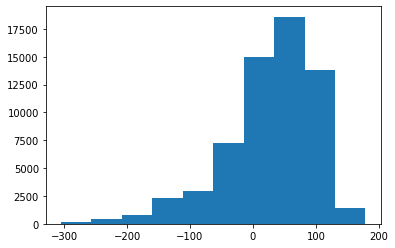

In [96]:
plt.hist(mooring_df['DOX2_error'])

In [97]:
mooring_df.TEMPERATURE_VALUE =(mooring_df.TEMPERATURE_VALUE * oxygen_stats.loc['TEMPERATURE_VALUE','std'])+oxygen_stats.loc['TEMPERATURE_VALUE','mean']
mooring_df.SALINITY_VALUE =(mooring_df.SALINITY_VALUE * oxygen_stats.loc['SALINITY_VALUE','std'])+oxygen_stats.loc['SALINITY_VALUE','mean']
# mooring_df.PRESSURE =(mooring_df.PRESSURE * oxygen_stats.loc['PRESSURE','std'])+oxygen_stats.loc['PRESSURE','mean']
mooring_df.Year =(mooring_df.Year * oxygen_stats.loc['Year','std'])+oxygen_stats.loc['Year','mean']
mooring_df.Yday =(mooring_df.Yday * oxygen_stats.loc['Yday','std'])+oxygen_stats.loc['Yday','mean']
mooring_df.Hour =(mooring_df.Hour * oxygen_stats.loc['Hour','std'])+oxygen_stats.loc['Hour','mean']

In [98]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
0,-1.136492,2012-11-28 22:00:00,219.715591,20.759911,35.461388,2012.0,333.0,22.0,191.269196,28.446396
1,-1.087740,2012-11-28 22:00:00,219.631363,20.770100,35.460751,2012.0,333.0,22.0,190.373611,29.257751
2,-0.990236,2013-06-15 07:00:00,205.350891,19.003767,35.462334,2013.0,166.0,7.0,112.922050,92.428841
3,-0.990236,2013-06-15 08:00:00,205.339203,18.982601,35.463001,2013.0,166.0,8.0,117.785461,87.553741
4,-0.990236,2013-06-15 21:00:00,208.561523,18.965900,35.501999,2013.0,166.0,21.0,246.425446,-37.863922
...,...,...,...,...,...,...,...,...,...,...
62727,-0.405214,2010-05-21 10:00:00,210.213242,22.698212,35.327530,2010.0,141.0,10.0,158.802689,51.410553
62728,-0.405214,2010-05-21 11:00:00,210.027222,22.679289,35.324860,2010.0,141.0,11.0,162.020569,48.006653
62729,-0.405214,2010-05-21 12:00:00,209.906219,22.679312,35.319817,2010.0,141.0,12.0,165.005417,44.900803
62730,-0.405214,2016-04-01 05:00:00,161.294037,24.785011,35.544964,2016.0,92.0,5.0,147.765533,13.528503


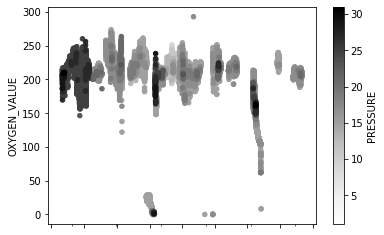

In [98]:
mooring_df.plot.scatter('TIME','OXYGEN_VALUE',c='PRESSURE')

In [99]:
mooring_df.groupby('PRESSURE').count()

,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
PRESSURE,,,,,,,,,
1.0,1,1,1,1,1,1,1,1,1
3.0,1,1,1,1,1,1,1,1,1
7.0,189,189,189,189,189,189,189,189,189
9.0,3047,3047,3047,3047,3047,3047,3047,3047,3047
11.0,3382,3382,3382,3382,3382,3382,3382,3382,3382
13.0,8405,8405,8405,8405,8405,8405,8405,8405,8405
15.0,26249,26249,26249,26249,26249,26249,26249,26249,26249
17.0,9507,9507,9507,9507,9507,9507,9507,9507,9507
19.0,1071,1071,1071,1071,1071,1071,1071,1071,1071


In [138]:
plot_df = mooring_df.where((mooring_df.PRESSURE>13) & (mooring_df.PRESSURE<16)).dropna()
# mooring_df.where((mooring_df.PRESSURE==15.0)).dropna()

In [139]:
plot_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
15025,15.0,2011-03-30 02:00:00,207.406555,23.874733,35.421001,2011.0,89.0,2.0,177.838867,29.567688
15026,15.0,2011-03-30 23:00:00,205.592316,24.032101,35.394669,2011.0,89.0,23.0,234.460815,-28.868500
15027,15.0,2011-03-31 00:00:00,205.822815,23.990505,35.395649,2011.0,90.0,0.0,301.231262,-95.408447
15028,15.0,2011-03-31 01:00:00,206.022751,23.955677,35.400547,2011.0,90.0,1.0,221.052155,-15.029404
15029,15.0,2011-03-31 02:00:00,206.452667,23.911592,35.403381,2011.0,90.0,2.0,178.483475,27.969193
...,...,...,...,...,...,...,...,...,...,...
41269,15.0,2017-08-27 13:00:00,209.932739,18.792896,35.667912,2017.0,239.0,13.0,145.746658,64.186081
41270,15.0,2017-08-27 14:00:00,210.159729,18.775326,35.667591,2017.0,239.0,14.0,154.523331,55.636398
41271,15.0,2017-08-27 15:00:00,210.691208,18.669523,35.669529,2017.0,239.0,15.0,162.241272,48.449936
41272,15.0,2017-08-27 16:00:00,211.089798,18.511110,35.671211,2017.0,239.0,16.0,169.491867,41.597931


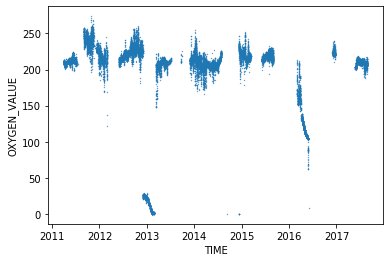

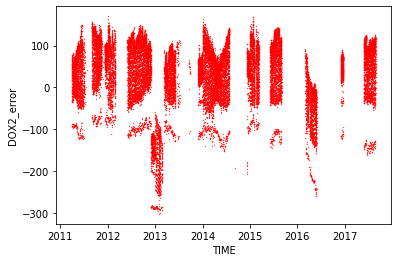

In [128]:
plot_df.plot.scatter('TIME','OXYGEN_VALUE',s=0.1)
plot_df.plot.scatter('TIME', 'DOX2_error',c='r',s=0.1)

In [159]:
temp = plot_df.where((mooring_df.DOX2_error < 20) & (mooring_df.DOX2_error > -20)).dropna()

In [160]:
temp

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
15028,15.0,2011-03-31 01:00:00,206.022751,23.955677,35.400547,2011.0,90.0,1.0,221.052155,-15.029404
15043,15.0,2011-03-31 16:00:00,207.307846,23.617336,35.422607,2011.0,90.0,16.0,190.914795,16.393051
15044,15.0,2011-03-31 17:00:00,207.345306,23.603033,35.425041,2011.0,90.0,17.0,198.152420,9.192886
15045,15.0,2011-03-31 18:00:00,207.629807,23.576160,35.428406,2011.0,90.0,18.0,205.724579,1.905228
15046,15.0,2011-03-31 19:00:00,207.436325,23.583130,35.427765,2011.0,90.0,19.0,212.975769,-5.539444
...,...,...,...,...,...,...,...,...,...,...
41241,15.0,2017-08-25 21:00:00,208.320831,17.795134,35.689640,2017.0,237.0,21.0,221.363037,-13.042206
41245,15.0,2017-08-26 01:00:00,207.603455,17.589165,35.678226,2017.0,238.0,1.0,205.405807,2.197647
41263,15.0,2017-08-26 19:00:00,204.377441,18.722832,35.766171,2017.0,238.0,19.0,191.928680,12.448761
41264,15.0,2017-08-26 20:00:00,205.087646,18.698603,35.762321,2017.0,238.0,20.0,206.633652,-1.546005


Text(0.5, 0, 'Temperature (degree Celsius)')

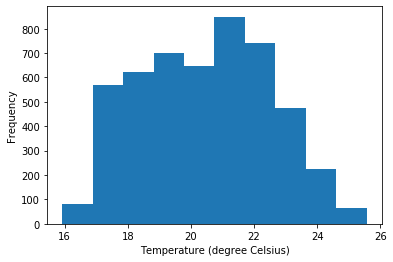

In [162]:
temp.TEMPERATURE_VALUE.plot.hist()
plt.xlabel('Temperature (degree Celsius)')

Text(0.5, 0, 'Salinity (g/L)')

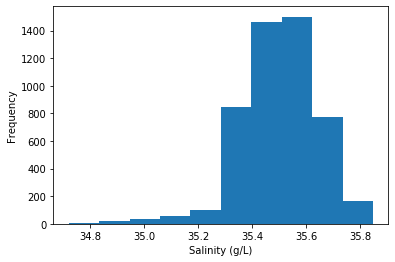

In [164]:
temp.SALINITY_VALUE.plot.hist()
plt.xlabel('Salinity (g/L)')

Text(0.5, 0, 'Day of year')

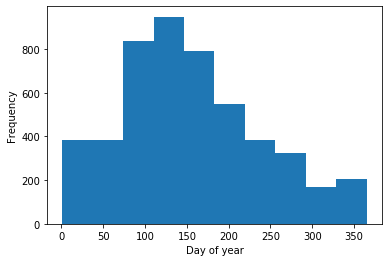

In [165]:
temp.Yday.plot.hist()
plt.xlabel('Day of year')

Text(0.5, 0, 'Hour')

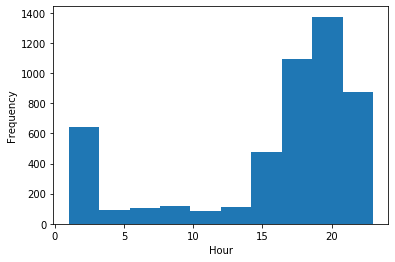

In [166]:
temp.Hour.plot.hist()
plt.xlabel('Hour')